# Reading data

In [1]:
import pandas as pd

data = pd.read_csv ('housing.csv')
print ("Data Shape:", data.shape)
data.head()


Data Shape: (20640, 10)


,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


# Preprocessing

In [2]:
#Checking Missing Value
 
print (data.isnull().mean()*100)

longitude             0.000000
latitude              0.000000
housing_median_age    0.000000
total_rooms           0.000000
total_bedrooms        1.002907
population            0.000000
households            0.000000
median_income         0.000000
median_house_value    0.000000
ocean_proximity       0.000000
dtype: float64


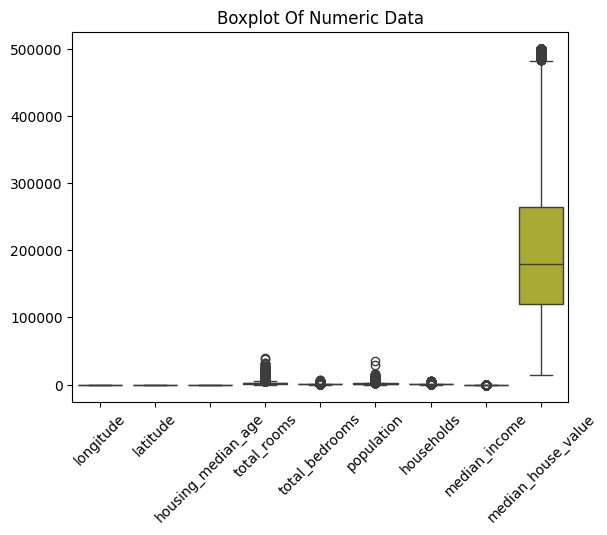

In [3]:
#Checking Outliers

import seaborn as sns
import matplotlib.pyplot as plt

numeric_data = data.select_dtypes (include = 'number')
sns.boxplot (data = numeric_data)
plt.xticks (rotation = 45)
plt.title ('Boxplot Of Numeric Data')
plt.show()

In [4]:
#Confusion Matrix for Numerical data

confusion_matrix = data.drop('ocean_proximity', axis=1).corr()
print (confusion_matrix)

                    longitude  latitude  housing_median_age  total_rooms  \
longitude            1.000000 -0.924664           -0.108197     0.044568   
latitude            -0.924664  1.000000            0.011173    -0.036100   
housing_median_age  -0.108197  0.011173            1.000000    -0.361262   
total_rooms          0.044568 -0.036100           -0.361262     1.000000   
total_bedrooms       0.069608 -0.066983           -0.320451     0.930380   
population           0.099773 -0.108785           -0.296244     0.857126   
households           0.055310 -0.071035           -0.302916     0.918484   
median_income       -0.015176 -0.079809           -0.119034     0.198050   
median_house_value  -0.045967 -0.144160            0.105623     0.134153   

                    total_bedrooms  population  households  median_income  \
longitude                 0.069608    0.099773    0.055310      -0.015176   
latitude                 -0.066983   -0.108785   -0.071035      -0.079809   
housing_

In [5]:
data = data.drop (['total_rooms', 'households', 'population'], axis= 1)

# Model Training and Evaluating

In [6]:
#Splitting data to 3 sections (train, validation, and test)

from sklearn.model_selection import train_test_split


X = data.drop ('median_house_value', axis=1)
y = data ['median_house_value']

x_temp, x_test, y_temp, y_test = train_test_split (X, y, test_size=0.2, random_state=42)

x_train, x_val, y_train, y_val = train_test_split (x_temp, y_temp, test_size=0.2, random_state=42)

In [7]:
from imblearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder


num_cols = X.select_dtypes(include='number').columns.to_list()
cat_cols = ['ocean_proximity']
col_to_impute = ['total_bedrooms']


num_pipe = Pipeline ([
    ('scaling', StandardScaler())
])

cat_pipe = Pipeline ([
     ('encoding', OneHotEncoder(handle_unknown='ignore'))
])

impute_pipe = Pipeline ([
    ('imputing', SimpleImputer(strategy="median"))
])

preprocessor = ColumnTransformer ([
    ('num', num_pipe, num_cols),
    ('impute', impute_pipe, col_to_impute),
    ('cat', cat_pipe, cat_cols)
])



In [8]:
from xgboost import XGBRegressor

full_pipeline = Pipeline ([
    ('preprocessing', preprocessor),
    ('regressor', XGBRegressor (n_estimators=300, learning_rate=0.1, max_depth=5, subsample=0.8, random_state=42))
])


In [12]:
full_pipeline.fit (x_train, y_train)

Pipeline(steps=[('preprocessing',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('scaling',
                                                                   StandardScaler())]),
                                                  ['longitude', 'latitude',
                                                   'housing_median_age',
                                                   'total_bedrooms',
                                                   'median_income']),
                                                 ('impute',
                                                  Pipeline(steps=[('imputing',
                                                                   SimpleImputer(strategy='median'))]),
                                                  ['total_bedrooms']),
                                                 ('cat',
                                                  Pipeline(steps=[('encoding',
                                                                   OneHotEncoder(handle_u...
                              feature_types=None, feature_weights=None,
                              gamma=None, grow_policy=None,
                              importance_type=None,
                              interaction_constraints=None, learning_rate=0.1,
                              max_bin=None, max_cat_threshold=None,
                              max_cat_to_onehot=None, max_delta_step=None,
                              max_depth=5, max_leaves=None,
                              min_child_weight=None, missing=nan,
                              monotone_constraints=None, multi_strategy=None,
                              n_estimators=300, n_jobs=None,
                              num_parallel_tree=None, ...))])

In [13]:
#Evaluate on val set

import numpy as np
from sklearn.metrics import mean_squared_error

y_pred = full_pipeline.predict (x_val)
rmse = np.sqrt (mean_squared_error(y_val, y_pred))
print ("Validation RMSE:", rmse)

Validation RMSE: 49768.54611865194


In [16]:
#Cross Validation

from sklearn.model_selection import cross_val_score, StratifiedKFold

cv = StratifiedKFold (n_splits=5, shuffle=True, random_state=42)

scores = cross_val_score (full_pipeline, x_train, y_train, cv=cv, scoring='neg_root_mean_squared_error')

print ("CV RMSE", -scores.mean(), "mean:", scores.mean(), "+/-", scores.std())

c:\Users\ASUS\Desktop\housing\venv\Lib\site-packages\sklearn\model_selection\_split.py:805: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(


CV RMSE 48171.87851049312 mean: -48171.87851049312 +/- 402.7702368869967


In [17]:
#Hyperparameter tuning

from sklearn.model_selection import RandomizedSearchCV

param_dist = {
    'regressor__n_estimators': [100, 300, 400],
    'regressor__learning_rate': [0.01, 0.05, 0.1],
    'regressor__max_depth': [3, 5, 7,9],
    'regressor__subsample': [0.6, 0.8, 1.0],
    'regressor__colsample_bytree': [0.6, 0.8, 1.0]
}


random_search = RandomizedSearchCV (estimator=full_pipeline, param_distributions=param_dist, n_iter=20, cv=5, scoring='neg_root_mean_squared_error', verbose=1, n_jobs=-1, random_state=42)
random_search.fit (x_train, y_train)

print("Best params:", random_search.best_params_)
print("Best params:", -random_search.best_score_)

Fitting 5 folds for each of 20 candidates, totalling 100 fits
Best params: {'regressor__subsample': 1.0, 'regressor__n_estimators': 400, 'regressor__max_depth': 9, 'regressor__learning_rate': 0.05, 'regressor__colsample_bytree': 0.8}
Best params: 47506.936327152194


In [ ]:
# Final evaluation on test set

y_pred_test_simple = full_pipeline.predict (x_test)
rmse_simple = np.sqrt (mean_squared_error (y_test, y_pred_test_simple))

best_model = random_search.best_estimator_
y_pred_test_bestmpdel = best_model.predict (x_test)
rmse_bestmodel= np.sqrt (mean_squared_error (y_test, y_pred_test_bestmpdel))

print('simple model RMSE:', rmse_simple)
print('grid model RMSE:', rmse_bestmodel)

simple model RMSE: 47761.38840257172
grid model RMSE: 47416.800314956585


# Saving :)

In [19]:
import joblib

joblib.dump (best_model, 'best_model.pkl')

['best_model.pkl']